# Logistic Regression

In [49]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [50]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[[
        "latitude",
        "longitude",
        "housing_median_age",
        "total_rooms",
        "total_bedrooms",
        "population",
        "households",
        "median_income"
    ]]
    processed_features = selected_features.copy()
    
    # Create a synthetic feature.
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"])
    return processed_features

In [51]:
def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    # Create a boolean categorical feature representing whether the
    # median_house_value is above a set threshold.
    output_targets["median_house_value_is_high"] = (
        california_housing_dataframe["median_house_value"] > 265000).astype(float)
    return output_targets

In [52]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2633.6,537.8,1425.2,500.5,3.9,2.0
std,2.1,2.0,12.6,2166.4,420.8,1120.6,384.5,1.9,1.2
min,32.5,-124.3,1.0,8.0,1.0,3.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1459.8,296.0,790.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2122.0,433.0,1166.0,409.0,3.6,1.9
75%,37.7,-118.0,37.0,3126.2,648.0,1718.0,605.0,4.8,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,28566.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.6,2667.7,543.2,1440.1,503.0,3.9,2.0
std,2.1,2.0,12.6,2212.1,423.3,1210.8,384.5,2.0,1.0
min,32.6,-124.3,2.0,2.0,2.0,6.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1467.0,299.0,786.8,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2147.5,437.0,1168.5,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3207.2,650.0,1730.0,606.0,4.8,2.3
max,41.8,-114.5,52.0,37937.0,5471.0,35682.0,5189.0,15.0,22.6


Training targets summary:


,median_house_value_is_high
count,12000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Validation targets summary:


,median_house_value_is_high
count,5000.0
mean,0.3
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


In [53]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [54]:
def construct_feature_columns(input_features):
      return set([tf.feature_column.numeric_column(my_feature) 
                  for my_feature in input_features])

In [61]:
def train_linear_classifier_model(learning_rate, 
                                  steps,
                                  batch_size,
                                  training_examples,
                                  training_targets,
                                  validation_examples,
                                  validation_targets):
    
    periods = 10
    steps_per_period = steps / periods
        
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.LinearClassifier(
        feature_columns=construct_feature_columns(training_examples),
        optimizer=my_optimizer
    )
    
    training_input_fn = lambda: my_input_fn(training_examples, 
                                            training_targets["median_house_value_is_high"], 
                                            batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                    training_targets["median_house_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                      validation_targets["median_house_value_is_high"], 
                                                      num_epochs=1, 
                                                      shuffle=False)
        
    print("Training model...")
    print("LogLoss (on training data):")
    training_log_losses = []
    validation_log_losses = []
    
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )

        # Take a break and compute probabilites.
        training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
        validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])

        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
        
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_log_loss))
        # Add the loss metrics from this period to our list.
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
        
    print("Model training finished.")
    
    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training")
    plt.plot(validation_log_losses, label="validation")
    plt.legend()

    return linear_classifier

Training model...
LogLoss (on training data):
  period 00 : 0.60
  period 01 : 0.58
  period 02 : 0.56
  period 03 : 0.55
  period 04 : 0.55
  period 05 : 0.54
  period 06 : 0.55
  period 07 : 0.54
  period 08 : 0.53
  period 09 : 0.53
Model training finished.


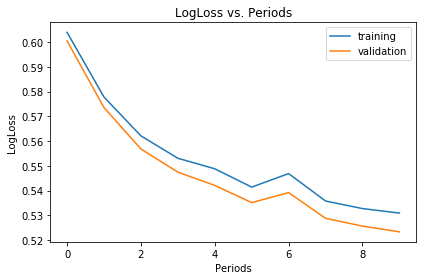

In [62]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.000005,
    steps=500,
    batch_size=20,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

In [66]:
predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                  validation_targets["median_house_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)

evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)

print("AUC on the validation set: %0.2f" % evaluation_metrics['auc'])
print("Accuracy on the validation set: %0.2f" % evaluation_metrics['accuracy'])

AUC on the validation set: 0.74
Accuracy on the validation set: 0.76
